**Stock news gathered from multiple Twitter handles regarding economic news is divided into two categories: negative (-1) and positive (1).**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re


from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, LSTM, Bidirectional, Dense, Dropout
from keras.regularizers import l2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import pandas as pd

df=pd.read_csv("stock_data.csv")
df.head(10)

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
5,PGNX Over 3.04,1
6,AAP - user if so then the current downtrend wi...,-1
7,Monday's relative weakness. NYX WIN TIE TAP IC...,-1
8,GOOG - ower trend line channel test & volume s...,1
9,AAP will watch tomorrow for ONG entry.,1


In [4]:
df.columns = ['text', 'sentiment']
df.head()

,text,sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


<Axes: xlabel='sentiment', ylabel='count'>

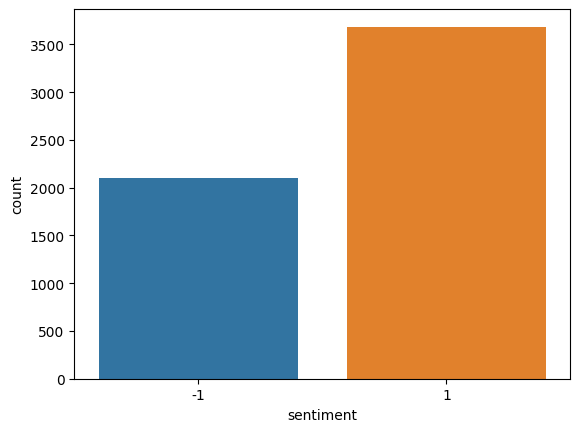

In [5]:
sns.countplot(x='sentiment', data=df)

This line "clean = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+" uses regular expressions to clean and preprocess the input text:

    - @\S+: This part matches Twitter handles (e.g., @username).
    - https?:\S+|http?:\S: This part matches URLs.
    - [^A-Za-z0-9]+: This part matches any character that is not an uppercase letter, a lowercase letter, or a digit (0-9).

In [33]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

clean = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [34]:
def prepare(text, stem=False):  #Preprocessing the texts
  text_prepared = re.sub(clean, ' ', str(text).lower()).strip()
  tokens = [token if not stem else stemmer.stem(token) for token in text_prepared.split() if token not in stop_words]
  return " ".join(tokens)

In [35]:
df.text = df.text.apply(lambda x: prepare(x))

In [40]:
train_size = 0.8
num_words = 10000
max_length = 30

Split of the data to training-set and testing-set:

In [10]:
train_data, test_data = train_test_split(df, test_size=1-train_size, random_state=42)

print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 4632
Test Data size 1159


Creating the Tokenizer:

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

In [12]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 7947


Padding:

In [13]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = max_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = max_length)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (4632, 30)
Testing X Shape: (1159, 30)


Label encoding is applied to the sentiment labels in the dataset to convert the non-integer values into numerical representations:

In [38]:
label_encoder = LabelEncoder()

# transforming the "sentiment" column in the training data
train_data['sentiment_encoded'] = label_encoder.fit_transform(train_data['sentiment'])
test_data['sentiment_encoded'] = label_encoder.transform(test_data['sentiment'])

# training and testing labels
y_train = train_data['sentiment_encoded']
y_test = test_data['sentiment_encoded']

# Size reshaped to ensure the match with the input data
y_train = train_data['sentiment_encoded'].values.reshape(-1, 1)
y_test = test_data['sentiment_encoded'].values.reshape(-1, 1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (4632, 1)
y_test shape: (1159, 1)


Building the model:

In [15]:
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 16)            1600000   
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 6)                 2886      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1602893 (6.11 MB)
Trainable params: 1602893 (6.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
NUM_EPOCHS = 25
BATCH_SIZE = 128

history_flatten = model_flatten.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/25
37/37 [==============================] - 2s 31ms/step - loss: 0.6787 - accuracy: 0.6157 - val_loss: 0.6573 - val_accuracy: 0.6428
Epoch 2/25
37/37 [==============================] - 1s 23ms/step - loss: 0.6511 - accuracy: 0.6347 - val_loss: 0.6494 - val_accuracy: 0.6428
Epoch 3/25
37/37 [==============================] - 1s 23ms/step - loss: 0.6356 - accuracy: 0.6347 - val_loss: 0.6417 - val_accuracy: 0.6428
Epoch 4/25
37/37 [==============================] - 1s 24ms/step - loss: 0.6064 - accuracy: 0.6347 - val_loss: 0.6262 - val_accuracy: 0.6428
Epoch 5/25
37/37 [==============================] - 1s 23ms/step - loss: 0.5538 - accuracy: 0.6673 - val_loss: 0.5985 - val_accuracy: 0.6566
Epoch 6/25
37/37 [==============================] - 1s 23ms/step - loss: 0.4682 - accuracy: 0.8076 - val_loss: 0.5546 - val_accuracy: 0.7015
Epoch 7/25
37/37 [==============================] - 1s 23ms/step - loss: 0.3268 - accuracy: 0.9197 - val_loss: 0.5037 - val_accuracy: 0.7619
Epoch 8/25
37

In [17]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

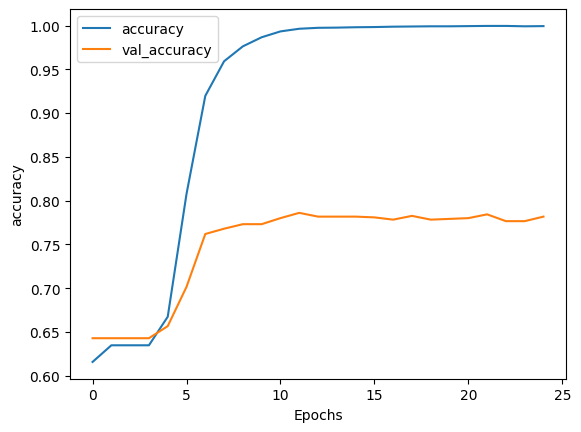

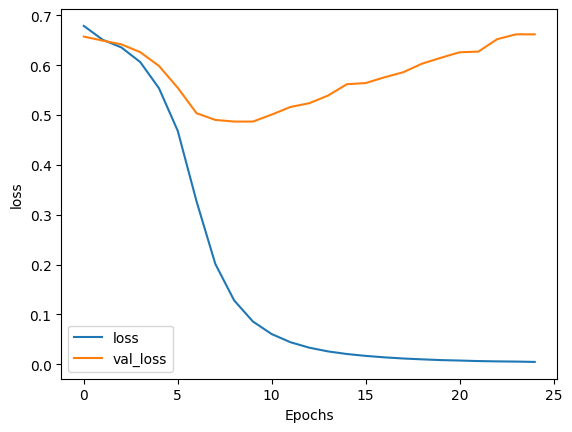

In [18]:
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

To address the issue of overfitting, particularly the behavior of the validation loss that decreases and then increases, we have adopted a simplified model architecture. This model consists of an embedding layer, a reduced LSTM layer with 64 units, and dropout layers with a dropout rate of 0.2 for both input and recurrent connections. Additionally, there is a single dense layer with a sigmoid activation function for binary classification. This approach aims to reduce model complexity while promoting robustness against overfitting:

In [44]:
embedding_dim = 16

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 16)            160000    
                                                                 
 lstm_5 (LSTM)               (None, 64)                20736     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 180801 (706.25 KB)
Trainable params: 180801 (706.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
NUM_EPOCHS = 25
BATCH_SIZE = 128

history_lstm = model_lstm.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/25
37/37 [==============================] - 8s 86ms/step - loss: 0.6654 - accuracy: 0.6321 - val_loss: 0.6483 - val_accuracy: 0.6428
Epoch 2/25
37/37 [==============================] - 2s 67ms/step - loss: 0.6300 - accuracy: 0.6360 - val_loss: 0.5984 - val_accuracy: 0.6601
Epoch 3/25
37/37 [==============================] - 2s 67ms/step - loss: 0.4778 - accuracy: 0.7869 - val_loss: 0.5404 - val_accuracy: 0.7610
Epoch 4/25
37/37 [==============================] - 3s 68ms/step - loss: 0.3206 - accuracy: 0.8828 - val_loss: 0.4745 - val_accuracy: 0.7748
Epoch 5/25
37/37 [==============================] - 4s 101ms/step - loss: 0.2391 - accuracy: 0.9195 - val_loss: 0.5483 - val_accuracy: 0.7852
Epoch 6/25
37/37 [==============================] - 2s 67ms/step - loss: 0.1715 - accuracy: 0.9421 - val_loss: 0.5436 - val_accuracy: 0.7808
Epoch 7/25
37/37 [==============================] - 2s 66ms/step - loss: 0.1325 - accuracy: 0.9575 - val_loss: 0.5897 - val_accuracy: 0.7981
Epoch 8/25
3

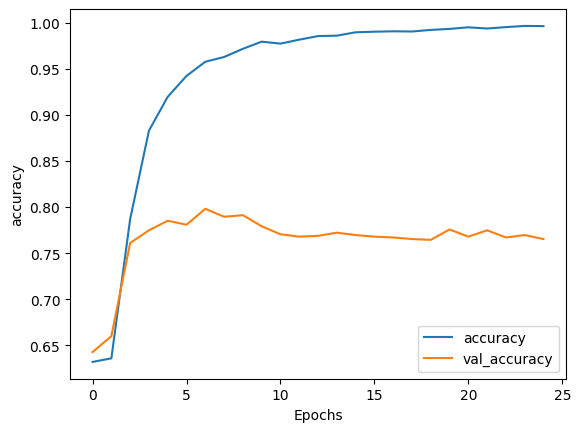

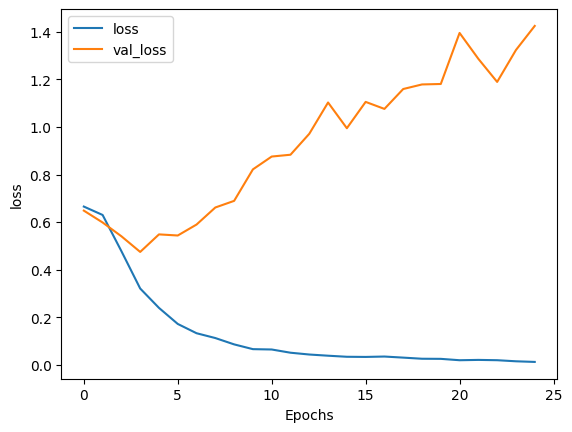

In [43]:
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In the model_lstm2:

- SpatialDropout1D Layer (0.2): Added for preventing overfitting.

- Conv1D Layer: Included to capture local patterns in text data.

- Dropout Layers (0.5): Implemented to enhance generalization.

- Dense Layers (256, L2 Regularization): Added for capturing higher-level patterns

In [45]:
model_lstm2 = Sequential([
    Embedding(num_words, embedding_dim, input_length=max_length),
    SpatialDropout1D(0.2),
    Conv1D(32, 5, activation='relu'),
    Dropout(0.5),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 30, 16)            160000    
                                                                 
 spatial_dropout1d_3 (Spati  (None, 30, 16)            0         
 alDropout1D)                                                    
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 32)            2592      
                                                                 
 dropout_7 (Dropout)         (None, 26, 32)            0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 64)               

In [28]:
history_lstm2 = model_lstm2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/25
37/37 [==============================] - 13s 163ms/step - loss: 2.9567 - accuracy: 0.6222 - val_loss: 1.8785 - val_accuracy: 0.6428
Epoch 2/25
37/37 [==============================] - 4s 107ms/step - loss: 1.3925 - accuracy: 0.6347 - val_loss: 1.0147 - val_accuracy: 0.6428
Epoch 3/25
37/37 [==============================] - 4s 114ms/step - loss: 0.8656 - accuracy: 0.6347 - val_loss: 0.7473 - val_accuracy: 0.6428
Epoch 4/25
37/37 [==============================] - 5s 144ms/step - loss: 0.6916 - accuracy: 0.6347 - val_loss: 0.6141 - val_accuracy: 0.6428
Epoch 5/25
37/37 [==============================] - 4s 109ms/step - loss: 0.5067 - accuracy: 0.7077 - val_loss: 0.5620 - val_accuracy: 0.7506
Epoch 6/25
37/37 [==============================] - 4s 108ms/step - loss: 0.4043 - accuracy: 0.8905 - val_loss: 0.5820 - val_accuracy: 0.7627
Epoch 7/25
37/37 [==============================] - 5s 144ms/step - loss: 0.3535 - accuracy: 0.9223 - val_loss: 0.7936 - val_accuracy: 0.7601
Epoch

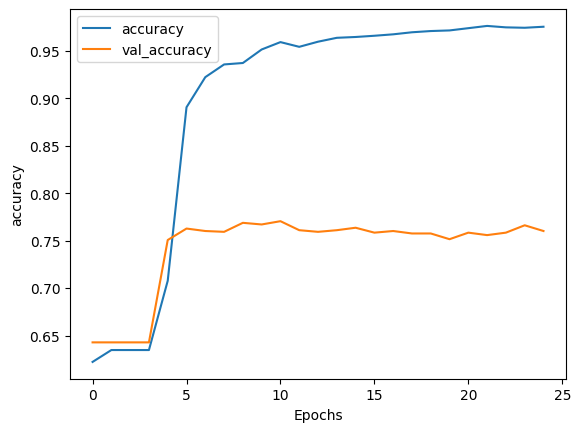

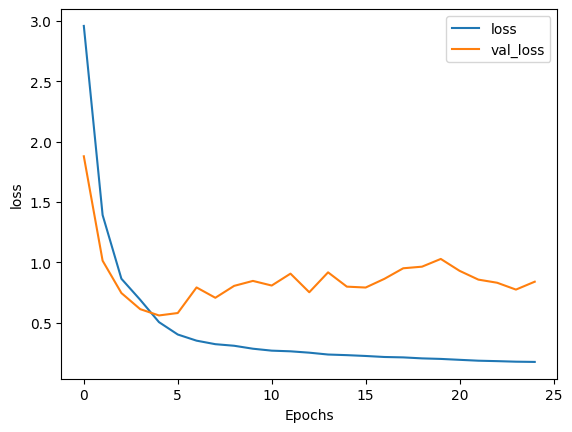

In [29]:
plot_graphs(history_lstm2, 'accuracy')
plot_graphs(history_lstm2, 'loss')

Test on real texts that the model never saw:

In [30]:
real_text = "The stock market is on a steady upward trajectory, with gains across various sectors. Consumer confidence is at an all-time high, and economic indicators point to a thriving economy."

# Tokenization of the text
real_text = [real_text]
real_text_sequences = tokenizer.texts_to_sequences(real_text)

# Padding the sequences to match the input length
real_text_padded = pad_sequences(real_text_sequences, maxlen=max_length)

# Make predictions using the trained model
predictions = model_lstm2.predict(real_text_padded)

# Interpretation of the prediction
if predictions[0] < 0.5:
    sentiment_label = "Negative"
else:
    sentiment_label = "Positive"

print("Market Sentiment Prediction:", sentiment_label)

1/1 [==============================] - 1s 543ms/step
Market Sentiment Prediction: Positive


In [31]:
real_text = "Poor earnings reports from major companies have sent shockwaves through the financial markets, leading to widespread panic selling."

real_text = [real_text]
real_text_sequences = tokenizer.texts_to_sequences(real_text)

real_text_padded = pad_sequences(real_text_sequences, maxlen=max_length)
predictions = model_lstm2.predict(real_text_padded)

if predictions[0] < 0.5:
    sentiment_label = "Negative"
else:
    sentiment_label = "Positive"

print("Market Sentiment Prediction:", sentiment_label)

1/1 [==============================] - 0s 30ms/step
Market Sentiment Prediction: Negative
